## Import and install

In [ ]:
#mount google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchtnt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 16.0 MB/s eta 0:00:00


In [ ]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 16.4 MB/s eta 0:00:00


In [ ]:
!pip install torchsnapshot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.5 MB/s eta 0:00:00


In [ ]:
import os
import copy
import itertools
import logging
import glob

from functools import partial
from datetime import datetime
from random import randint,shuffle

import numpy as np
from numpy import genfromtxt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import argparse
import logging
import tempfile
import uuid
from argparse import Namespace
from typing import Literal, Optional, Tuple, Union

import torch
import torch.nn as nn
from torch.distributed import launcher as pet
from torch.utils.data.dataset import Dataset, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix, MulticlassF1Score
from torchtnt.framework.auto_unit import AutoUnit, Strategy, SWAParams, TrainStepResults
from torchtnt.framework.fit import fit
from torchtnt.framework.state import EntryPoint, State
from torchtnt.utils import init_from_env, seed, TLRScheduler
from torchtnt.utils.loggers import TensorBoardLogger
from torchtnt.utils.prepare_module import ActivationCheckpointParams, TorchCompileParams
from torchtnt.framework.callbacks.garbage_collector import GarbageCollector
from torchtnt.framework.callbacks.torchsnapshot_saver import TorchSnapshotSaver
from torchtnt.framework.callbacks.tqdm_progress_bar import TQDMProgressBar

In [ ]:
_logger: logging.Logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## Data Handling

Please switch the pipeline required for training detectors and classifiers by selecting one of the two functions read_annotation_binary or read_annotation_multi.

In [ ]:
MAIN_FOLDER = "/content/drive/MyDrive/AutoGR/SHREC2021/"
MAIN_FOLDER = "/content/drive/MyDrive/Colab Notebooks/shrec2021/"
# 17 semantic gestures
GESTURE_NAME = [
    'ONE', 'TWO', 'THREE', 'FOUR',
    'OK', 'MENU', 'LEFT', 'RIGHT',
    'CIRCLE', 'V', 'CROSS', 'GRAB',
    'PINCH', 'TAP', 'DENY', 'KNOB', 'EXPAND'
]

# 20 split joints
SPLIT_JOINT_NAME = [
    'palm',
    'thumbA', 'thumbB', 'thumbEnd',
    'indexA', 'indexB', 'indexC', 'indexEnd',
    'middleA', 'middleB', 'middleC', 'middleEnd',
    'ringA', 'ringB', 'ringC', 'ringEnd',
    'pinkyA', 'pinkyB', 'pinkyC', 'pinkyEnd'
]

SELECTED_GESTURE_NAME = GESTURE_NAME
SELECTED_JOINT_NAME = SPLIT_JOINT_NAME

INPUT_DIM = len(SELECTED_JOINT_NAME)*7
OUTPUT_DIM = len(SELECTED_GESTURE_NAME)
MAX_LENGTH = 250
BATCH_SIZE = 256

In [ ]:
def read_shrec_2021(path):
    gesture_data = []
    sequence_idx_list = []

    for i, fname in enumerate(sorted(glob.glob(path))):
        # print(fname)

        idx = fname.split('/')[-1].split('.')[0]
        # print(idx)

        data = genfromtxt(fname, delimiter=';')
        data_ = np.delete(data, -1, axis=1)
        gesture_data.append(data_)
        sequence_idx_list.append(int(idx))

    gesture_data_sorted = [x for _, x in sorted(zip(sequence_idx_list, gesture_data))]

    return gesture_data_sorted

In [ ]:
path = os.path.join(MAIN_FOLDER, 'training_set/sequences/*.txt')
gesture_data_train = read_shrec_2021(path)
path = os.path.join(MAIN_FOLDER, 'test_set/sequences/*.txt')
gesture_data_test = read_shrec_2021(path)

In [ ]:
# ts, dim
gesture_data_test[0].shape

(1913, 140)

In [ ]:
def read_annotation_binary(fname_, gesture_data, max_length=MAX_LENGTH):
    with open(fname_) as f:
        lines = f.readlines()

    annotation_idx_list = []
    gesture_name_list = []
    start_idx_list = []
    end_idx_list = []
    for i in range(len(lines)):
        annotation_idx_list.append(int(lines[i].split(';')[0]))
        gesture_name = lines[i].split(';')[1:-1][::3]
        start_idx = lines[i].split(';')[2:-1][::3]
        end_idx = lines[i].split(';')[0:-1][::3][1:]
        gesture_name_list.append(gesture_name)
        start_idx_list.append(start_idx)
        end_idx_list.append(end_idx)

    # Sort by comment index
    sorted_data = sorted(zip(annotation_idx_list, gesture_name_list, start_idx_list, end_idx_list))
    gesture_name_list = [x[1] for x in sorted_data]
    start_idx_list = [x[2] for x in sorted_data]
    end_idx_list = [x[3] for x in sorted_data]

    single_gesture = []
    gesture_class = []
    for i in range(len(gesture_data)):
        sequence_length = len(gesture_data[i])
        # Get the start and end indexes of all gestures in the current sequence
        gesture_starts = [int(idx) for idx in start_idx_list[i]]
        gesture_ends = [int(idx) for idx in end_idx_list[i]]

        # Initializing pointers
        prev_end = 0

        for j in range(len(gesture_starts)):
            start_idx = gesture_starts[j]
            end_idx = gesture_ends[j]

            # Extract the gesture-free fragment (from the end of the previous gesture to the start of the current gesture)
            if prev_end < start_idx:
                non_gesture_segment = gesture_data[i][prev_end:start_idx]
                if len(non_gesture_segment) > 0:
                    single_gesture.append(non_gesture_segment[:max_length])
                    gesture_class.append(0)  # Invalid gesture

            # Extract valid gesture fragments
            gesture_segment = gesture_data[i][start_idx:end_idx]
            single_gesture.append(gesture_segment[:max_length])
            gesture_class.append(1)  # Valid gesture

            # Update pointer
            prev_end = end_idx

        # Extract the gesture-free segment at the end of the sequence
        if prev_end < sequence_length:
            non_gesture_segment = gesture_data[i][prev_end:sequence_length]
            if len(non_gesture_segment) > 0:
                single_gesture.append(non_gesture_segment[:max_length])
                gesture_class.append(0)  # Invalid gesture

    return single_gesture, gesture_class


def read_annotation_multi(fname_, gesture_data, max_length=MAX_LENGTH):
    with open(fname_) as f:
        lines = f.readlines()

    annotation_idx_list = []
    gesture_name_list = []
    start_idx_list = []
    end_idx_list = []
    for i in range(len(lines)):
        annotation_idx_list.append(int(lines[i].split(';')[0]))
        gesture_name_list.append(lines[i].split(';')[1:-1][::3])
        start_idx_list.append(lines[i].split(';')[2:-1][::3])
        end_idx_list.append(lines[i].split(';')[0:-1][::3][1:])

    gesture_name_list = [x for _, x in sorted(zip(annotation_idx_list, gesture_name_list))]
    start_idx_list = [x for _, x in sorted(zip(annotation_idx_list, start_idx_list))]
    end_idx_list = [x for _, x in sorted(zip(annotation_idx_list, end_idx_list))]


    single_gesture = []
    gesture_class = []
    for i in range(len(gesture_data)):
        for j in range(len(gesture_name_list[i])):
            start_idx = int(start_idx_list[i][j])
            end_idx = int(end_idx_list[i][j])
            single_gesture.append(gesture_data[i][start_idx:start_idx+max_length])
            gesture_class.append(GESTURE_NAME.index(gesture_name_list[i][j]))

    return single_gesture, gesture_class

In [ ]:
anno_train = os.path.join(MAIN_FOLDER, 'training_set/annotations_revised_training.txt')
single_gesture_train, gesture_class_train = read_annotation_multi(anno_train, gesture_data_train)
anno_test = os.path.join(MAIN_FOLDER, 'test_set/annotations_revised.txt')
single_gesture_test, gesture_class_test = read_annotation_multi(anno_test, gesture_data_test)

In [ ]:
# single gesture ts, dim
single_gesture_test[0].shape

(250, 140)

In [ ]:
# class index
gesture_class_test[0]

0

In [ ]:
def select_joint(gesture_data, selected_joint=SELECTED_JOINT_NAME, pos = True, quat= True):
    """
    Column projection on selected joints
    """
    selected_joint_idx = []
    for x in selected_joint:
        selected_joint_idx.append(SPLIT_JOINT_NAME.index(x))

    # Every joint is represented as 7-dim with 3 dim for pos and 4 dim for quat
    # TODO: can be optimized with numpy
    idx_list_pos_x = np.multiply(selected_joint_idx,7)
    idx_list_pos_y = np.multiply(selected_joint_idx,7)+1
    idx_list_pos_z = np.multiply(selected_joint_idx,7)+2
    idx_list_quat_x = np.multiply(selected_joint_idx,7)+3
    idx_list_quat_y = np.multiply(selected_joint_idx,7)+4
    idx_list_quat_z = np.multiply(selected_joint_idx,7)+5
    idx_list_quat_w = np.multiply(selected_joint_idx,7)+6

    idx_list_pos = np.concatenate([idx_list_pos_x,idx_list_pos_y,idx_list_pos_z])
    idx_list_quat = np.concatenate([idx_list_quat_x,idx_list_quat_y,idx_list_quat_z,idx_list_quat_w])


    if pos:
        data = gesture_data[:,sorted(idx_list_pos)]
    if quat:
        data = gesture_data[:,sorted(idx_list_quat)]
    if pos and quat:
        data = gesture_data[:,sorted(np.concatenate([idx_list_pos,idx_list_quat]))]

    return data

In [ ]:
# Select specific joints from the training and testing data; column projection
selected_gesture_train = [select_joint(x) for x in single_gesture_train]
selected_gesture_test = [select_joint(x) for x in single_gesture_test]

In [ ]:
selected_gesture_test[0].shape

(250, 140)

In [ ]:
def pad_data(data, input_dim=INPUT_DIM, max_length=MAX_LENGTH):
    data_padded = np.zeros([len(data), max_length, input_dim])
    for i in range(len(data)):
        if len(data[i]) <= max_length:
            data_padded[i,:len(data[i])] = data[i]
        if len(data[i]) > max_length:
            data_padded[i] = data[i][:max_length]

    return data_padded

In [ ]:
# get data:
# ensure each single gesture has the same dimension by
# cutting or padding with 0s.
train_data = pad_data(selected_gesture_train)
assert not np.any(np.isnan(train_data))
test_data = pad_data(selected_gesture_test)
assert not np.any(np.isnan(test_data))

In [ ]:
# get labels:
train_label, test_label = np.array(gesture_class_train), np.array(gesture_class_test)

In [ ]:
train_data.shape

(912, 250, 140)

In [ ]:
train_label.shape

(912,)

In [ ]:
# random shuffle
def shuffle(data, label):
    data = np.asarray(data, dtype = object)
    shuffled_indexes = np.random.permutation(np.shape(data)[0])
    data = data[shuffled_indexes]
    label = label[shuffled_indexes]

    return data, label

train_data, train_label = shuffle(train_data, train_label)

In [ ]:
# set data type
train_data = np.asarray(train_data, dtype=np.float32)
test_data = np.asarray(test_data, dtype=np.float32)

train_label = np.asarray(train_label, dtype=np.int32)
test_label = np.asarray(test_label, dtype=np.int32)

In [ ]:
print(train_data.shape)
print(train_label.shape)

(912, 250, 140)
(912,)


In [ ]:
from scipy.spatial.transform import Rotation as R

from scipy.spatial.transform import Rotation as R

# Translation
def translate_joints(joints, translation_range):
    translation = np.random.uniform(-translation_range, translation_range, size=(1, 3))
    translated_joints = joints[:, :, :3] + translation
    return np.concatenate((translated_joints, joints[:, :, 3:]), axis=2)

# Rotation
def rotate_joints(joints, rotation_range):
    angle = np.random.uniform(-rotation_range, rotation_range)
    axis = np.random.normal(size=3)
    axis /= np.linalg.norm(axis)
    r = R.from_rotvec(angle * axis)
    # Normalize quaternions before applying rotations
    quats = joints[:, :, 3:]
    norms = np.linalg.norm(quats, axis=2, keepdims=True)
    norms[norms == 0] = 1e-6
    normalized_quats = quats / norms
    try:
        rotated_joints = np.array([r.apply(frame[:, :3]) for frame in joints])
        rotated_quats = np.array([(r * R.from_quat(frame)).as_quat() for frame in normalized_quats])
        return np.concatenate((rotated_joints, rotated_quats), axis=2)
    except Exception as e:
        return joints

# Scaling
def scale_joints(joints, scale_range):
    scale = np.random.uniform(1 - scale_range, 1 + scale_range, size=(1, 1, 3))
    scaled_joints = joints[:, :, :3] * scale
    return np.concatenate((scaled_joints, joints[:, :, 3:]), axis=2)

# Noise Injection
def add_noise(joints, noise_std):
    noisy_joints = joints[:, :, :3] + np.random.normal(0, noise_std, size=joints[:, :, :3].shape)
    noisy_quats = joints[:, :, 3:] + np.random.normal(0, noise_std, size=joints[:, :, 3:].shape)
    return np.concatenate((noisy_joints, noisy_quats), axis=2)

# Quaternion Normalization
def normalize_quaternions(joints):
    quats = joints[:, :, 3:]
    norms = np.linalg.norm(quats, axis=2, keepdims=True)
    normalized_quats = quats / norms
    return np.concatenate((joints[:, :, :3], normalized_quats), axis=2)

# Warp sequence by time
def time_warp(sequence, speed_factor):
    """
    Apply time warping to the sequence to mimic different speeds.

    Args:
        sequence (np.ndarray): The input sequence of shape [frames, 140].
        speed_factor (float): The factor by which to speed up (speed_factor > 1) or slow down (speed_factor < 1) the sequence.

    Returns:
        np.ndarray: The time-warped sequence of shape [new_frames, 140].
    """
    num_frames, num_features = sequence.shape
    new_num_frames = int(num_frames / speed_factor)
    # Interpolation indices
    original_indices = np.arange(num_frames)
    new_indices = np.linspace(0, num_frames - 1, new_num_frames)
    # Interpolate each feature
    warped_sequence = np.zeros((new_num_frames, num_features))
    for i in range(num_features):
        interp_function = interp1d(original_indices, sequence[:, i], kind='linear')
        warped_sequence[:, i] = interp_function(new_indices)
    data_padded = np.zeros((MAX_LENGTH, INPUT_DIM))
    data_padded[:warped_sequence.shape[0]] = warped_sequence
    return data_padded.astype(np.float32)

# Combining Augmentations
def augment_joints(sequence, translation_range, rotation_range, scale_range, noise_std):
    sequence = sequence.reshape(-1, 20, 7)  # Reshape to [250, 20, 7]
    sequence = translate_joints(sequence, translation_range)
    # sequence = rotate_joints(sequence, rotation_range)
    sequence = scale_joints(sequence, scale_range)
    sequence = add_noise(sequence, noise_std)
    sequence = normalize_quaternions(sequence)
    return sequence.reshape(-1, 140).astype(np.float32)  # Reshape back to [250, 140]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels, augment=False, time_warp=True):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.int64)
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def augment_sequence(self, joints):
        return augment_joints(joints, translation_range=0.25, rotation_range=np.pi/4, scale_range=0.25, noise_std=0.05)

    def __getitem__(self, idx):
        d = self.data[idx]
        if self.augment:
          d = self.augment_sequence(d)
        if time_warp:
          speed_factor = np.random.uniform(1, 1.5)
          d = time_warp(d, speed_factor=speed_factor)
        return d, self.labels[idx]

In [ ]:
train_set = MyDataset(train_data, train_label, augment=False, time_warp=True)
test_set = MyDataset(test_data, test_label)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
batch = next(iter(train_loader))
data, label = batch

In [ ]:
print(data.shape)
print(label.shape)

torch.Size([256, 250, 140])
torch.Size([256])


## Model Implementations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StreamingSightMu(nn.Module):
    def __init__(self, input_shape2, output_shape, cnn_features=10, rnn='LSTM', multi_rnn=True, attention=False, dropout=0.2, num_layers=2):
        super(StreamingSightMu, self).__init__()
        self.multi_rnn = multi_rnn
        self.attention = attention
        self.num_layers = num_layers

        rnn_output_size = 512  # Define the dimensions of the hidden state

        # Modified fully connected layer, the input dimension increases the dimension of the hidden state
        self.rnnsfc1 = nn.Linear(input_shape2 + rnn_output_size, rnn_output_size)
        self.dropout1 = nn.Dropout(p=dropout)
        self.rnnsfc2 = nn.Linear(rnn_output_size + rnn_output_size, rnn_output_size)
        self.dropout2 = nn.Dropout(p=dropout)
        self.rnnsfc3 = nn.Linear(rnn_output_size + rnn_output_size, rnn_output_size)
        self.dropout3 = nn.Dropout(p=dropout)

        # Fully connected layer
        self.flatten = nn.Flatten()
        flatten_size = 1 * 256 if attention else 1 * rnn_output_size  # Adjust based on whether to use the attention mechanism
        #self.fc1 = nn.Linear(flatten_size, 256)
        self.fc2 = nn.Linear(flatten_size, output_shape)

    # The forward function now accepts an external hidden state h
    def forward(self, x, h):
        # x: input tensor, shape is [batch_size, seq_length, input_size]
        # h: external hidden state, shape is [3, batch_size, hidden_size]

        batch_size, seq_length, input_size = x.size()
        x = x.squeeze(1)  # Assume seq_length=1

        # The first fully connected layer, the input is the concatenation of the current input and the hidden state
        xh1 = torch.cat([x, h[0]], dim=-1)
        nh0 = F.relu(self.rnnsfc1(xh1))
        nh0 = self.dropout1(nh0)
        # The second fully connected layer
        xh2 = torch.cat([nh0, h[1]], dim=-1)
        nh1 = F.relu(self.rnnsfc2(xh2))
        nh1 = self.dropout2(nh1)

        # The third fully connected layer
        xh3 = torch.cat([nh1, h[2]], dim=-1)
        nh2 = F.relu(self.rnnsfc3(xh3))
        nh2 = self.dropout3(nh2)

        # Flattened and passed through a fully connected layer
        x = self.flatten(nh2)  # Use the updated hidden state h
        x = F.relu(x)
        x = self.fc2(x)

        hnew = [nh0.detach(), nh1.detach(), nh2.detach()]
        # Returns the output and updated hidden state
        return F.log_softmax(x, dim=-1), hnew

class StreamingSightBi(nn.Module):
    def __init__(self, input_shape2, output_shape, cnn_features=10, rnn='LSTM', multi_rnn=True, attention=False, dropout=0.2, num_layers = 2):
        super(StreamingSightBi, self).__init__()
        self.multi_rnn = multi_rnn
        self.attention = attention
        self.num_layers = num_layers

        # Define the RNN type
        #rnn_layer = nn.LSTM if rnn == 'LSTM' else nn.GRU
        rnn_output_size = 256  # Hardcoded RNN output size


        # Define the RNN layers
        if multi_rnn:
            self.num_layers = 1
        else:
            self.num_layers = 1
        self.rnns = nn.LSTM(input_size=input_shape2, hidden_size=rnn_output_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)

        # Define attention if required
        if attention:
            self.attention_layer = nn.MultiheadAttention(embed_dim=256, num_heads=4, batch_first=True)

        # Fully connected layers
        self.flatten = nn.Flatten()
        # hardcoding ALERT: input_shape1=1

        flatten_size = 1 * 256 if attention else 1 * rnn_output_size  # Adjust based on the sequence length and attention
        self.fc2 = nn.Linear(flatten_size, output_shape)

    # Additionally receives external hidden state
    def forward(self, x, hPt, cPt):

        batch_size, _, _ = x.size()
        # Pass through the RNNs
        x, (hPt, cPt) = self.rnns(x, (hPt, cPt))

        # Apply attention if specified
        if self.attention:
            query, key = x.split(256, dim=2)  # Assuming the LSTM output is 400-dimensional, split into 2x200
            attention_output, _ = self.attention_layer(query, key, key)
            x = attention_output

        # Flatten and pass through dense layers
        x = self.flatten(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1), (hPt, cPt)

## Training

Note the hardcoded number of classification categories in this section, as well as the external hidden state parameters.

The main modification of the streaming model to the training pipeline is in the *compute_loss()* function.

The best hyperparameter settings found so far: 3-layer RNN (512), learning rate 0.001, batch size 256.

In [ ]:
# Creating an instance of the model
input_shape = data.shape
output_shape = 17  # Example output shape (number of classes)

In [ ]:
def prepare_module(model_type, input_shape, output_shape, device: torch.device) -> nn.Module:
    """
    Instantiate a nn.Module which will define the architecture of your model. If using a data parallel technique, wrap the module in DDP or FSDP.
    See https://pytorch.org/docs/stable/generated/torch.nn.Module.html for docs.
    """
    if model_type == "streamingBi":
        model = StreamingSightBi(140, 2)
    elif model_type == "streamingMu":
        model = StreamingSightMu(140, 17)
    return model.to(device)


def prepare_dataloader(data_loader, device: torch.device) -> torch.utils.data.DataLoader:
    """Instantiate DataLoader"""
    # pin_memory enables faster host to GPU copies
    # on_cuda = device.type == "cuda"
    return data_loader

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(
    cm_metric, idx=GESTURE_NAME, fig_size=(10,7), cmap="Spectral",
):
    df_cm = pd.DataFrame(
        torch.Tensor.cpu(cm_metric).numpy(),
        index=list(range(len(idx))),
        columns=idx,
    )
    plt.figure(figsize=fig_size)
    fig = sns.heatmap(df_cm, annot=True, cmap=cmap).get_figure()

    return fig

In [ ]:
Batch = Tuple[torch.Tensor, torch.Tensor]


class SHRECUnit(AutoUnit[Batch]):
    def __init__(
        self,
        *,
        train_accuracy: MulticlassAccuracy,
        eval_accuracy: MulticlassAccuracy,
        train_cm: MulticlassConfusionMatrix,
        eval_cm: MulticlassConfusionMatrix,
        log_every_n_steps: int,
        tb_logger: Optional[TensorBoardLogger] = None,
        module: torch.nn.Module,
        criterion: torch.nn.Module,
        device: Optional[torch.device] = None,
        strategy: Optional[Union[Strategy, str]] = None,
        step_lr_interval: Literal["step", "epoch"] = "epoch",
        precision: Optional[Union[str, torch.dtype]] = None,
        gradient_accumulation_steps: int = 1,
        detect_anomaly: Optional[bool] = None,
        clip_grad_norm: Optional[float] = None,
        clip_grad_value: Optional[float] = None,
        swa_params: Optional[SWAParams] = None,
        torch_compile_params: Optional[TorchCompileParams] = None,
        activation_checkpoint_params: Optional[ActivationCheckpointParams] = None,
        training: bool = True,
    ) -> None:
        super().__init__(
            module=module,
            device=device,
            strategy=strategy,
            step_lr_interval=step_lr_interval,
            precision=precision,
            gradient_accumulation_steps=gradient_accumulation_steps,
            detect_anomaly=detect_anomaly,
            clip_grad_norm=clip_grad_norm,
            clip_grad_value=clip_grad_value,
            swa_params=swa_params,
            torch_compile_params=torch_compile_params,
            activation_checkpoint_params=activation_checkpoint_params,
            training=training,
        )
        self.criterion = criterion
        self.tb_logger = tb_logger
        # create accuracy metrics to compute the accuracy of training and evaluation
        self.train_accuracy = train_accuracy
        self.eval_accuracy = eval_accuracy
        self.train_cm = train_cm
        self.eval_cm = eval_cm
        self.log_every_n_steps = log_every_n_steps

    def configure_optimizers_and_lr_scheduler(
        self, module: torch.nn.Module
    ) -> Tuple[torch.optim.Optimizer, Optional[TLRScheduler]]:
        optimizer = torch.optim.Adam(module.parameters(), lr=0.001)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)
        return optimizer, lr_scheduler




    def compute_loss(
        self, state: State, data: Batch
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        inputs, targets = data
        batch_size_current = inputs.size(0)
        max_length = inputs.size(1)
        # Hardcoding ALERT: num_layers=3, hiddensize=512
        # External memory initialization
        hPt = torch.zeros(3, batch_size_current, 512).to(device)
        cPt = torch.zeros(3, batch_size_current, 512).to(device)
        apecloss = 0
        outputs = 0
        juicebox = None
        for i in range(max_length):

            frames = inputs[:, i, :].unsqueeze(1)
            output, (hPt, cPt)= self.module(frames, hPt, cPt)
            #output, hPt= self.module(frames, hPt)
            loss = criterion(output, targets)
            apecloss += loss
            outputs += output

        apecloss = apecloss / max_length
        outputs = outputs / max_length

        #outputs = self.module(inputs)

        #loss = self.criterion(outputs, targets)

        return apecloss, outputs

    def on_train_step_end(
        self,
        state: State,
        data: Batch,
        step: int,
        results: TrainStepResults,
    ) -> None:
        loss, outputs = results.loss, results.outputs
        _, targets = data
        self.train_accuracy.update(outputs, targets)
        self.train_cm.update(outputs, targets)
        tb_logger = self.tb_logger

        if step % self.log_every_n_steps == 0 and tb_logger is not None:
            accuracy = self.train_accuracy.compute()
            tb_logger.add_scalar("train_accuracy", accuracy, step)
            tb_logger.add_scalar("train_loss", loss, step)

            # print(f"train_loss at step {step}: {loss}")

    def OLDon_train_epoch_end(self, state: State) -> None:
        super().on_train_epoch_end(state)
        # reset the metric every epoch
        cm = self.train_cm.compute()
        img = plot_cm(cm)
        epoch = self.train_progress.num_epochs_completed
        if tb_logger:
            tb_logger.add_figure("train_cm", img, epoch)
        if epoch % 10 == 0:
            if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/"):
                os.mkdir("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/")
            torch.save(self.module.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Duocheckpoint_{epoch}.pt")

        #print(f"train_cm at epoch {epoch}: {cm}")
        self.train_accuracy.reset()
        self.train_cm.reset()

    def on_train_epoch_end(self, state: State) -> None:
        super().on_train_epoch_end(state)
        # reset the metric every epoch

        epoch = self.train_progress.num_epochs_completed

        if epoch % 10 == 0:
            if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/"):
                os.mkdir("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/")
            torch.save(self.module.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Duocheckpoint_{epoch}.pt")

        #print(f"train_cm at epoch {epoch}: {cm}")
        self.train_accuracy.reset()
        self.train_cm.reset()

    def on_eval_step_end(
        self,
        state: State,
        data: Batch,
        step: int,
        loss: torch.Tensor,
        outputs: torch.Tensor,
    ) -> None:
        _, targets = data
        self.eval_accuracy.update(outputs, targets)
        self.eval_cm.update(outputs, targets)

    def OLDon_eval_end(self, state: State) -> None:
        if state.entry_point == EntryPoint.FIT:
            step = self.train_progress.num_steps_completed
            epoch = self.train_progress.num_epochs_completed
        else:
            step = self.eval_progress.num_steps_completed
            epoch = self.eval_progress.num_epochs_completed
        accuracy = self.eval_accuracy.compute()
        cm = self.eval_cm.compute()
        img = plot_cm(cm)

        tb_logger = self.tb_logger
        if tb_logger is not None:
            tb_logger.add_scalar("eval_accuracy", accuracy, step)
            tb_logger.add_figure("eval_cm", img, epoch)
        if accuracy > 0.89:
            if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/"):
                os.mkdir("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/")
            torch.save(self.module.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Duocheckpoint_eval.pt")
            print("Best!")
        print(f"eval_accuracy at epoch {epoch}: {accuracy}")
        # print(f"eval_cm: {cm}")
        self.eval_accuracy.reset()
        self.eval_cm.reset()

    def on_eval_end(self, state: State) -> None:
        if state.entry_point == EntryPoint.FIT:
            step = self.train_progress.num_steps_completed
            epoch = self.train_progress.num_epochs_completed
        else:
            step = self.eval_progress.num_steps_completed
            epoch = self.eval_progress.num_epochs_completed
        accuracy = self.eval_accuracy.compute()
        if accuracy > 0.89:
            if not os.path.exists("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/"):
                os.mkdir("/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/")
            torch.save(self.module.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Duocheckpoint_eval.pt")
            print("Best!")
        print(f"eval_accuracy at epoch {epoch}: {accuracy}")
        # print(f"eval_cm: {cm}")
        self.eval_accuracy.reset()
        self.eval_cm.reset()

In [ ]:
# seed the RNG for better reproducibility. see docs https://pytorch.org/docs/stable/notes/randomness.html
seed(0)

# device and process group initialization
device = init_from_env()

path = "/content/drive/MyDrive/Colab Notebooks/shrec2021/output/"
pathcheck = "/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Duocheckpoint_eval (1).pt"
tb_logger = SummaryWriter(log_dir=path)
checkpoint = torch.load(pathcheck)

module = prepare_module("streamingBi", input_shape, output_shape, device)
module.load_state_dict(checkpoint)
criterion = nn.CrossEntropyLoss()
train_accuracy = MulticlassAccuracy(device=device)
eval_accuracy = MulticlassAccuracy(device=device)
train_cm = MulticlassConfusionMatrix(num_classes=output_shape, device=device)
eval_cm = MulticlassConfusionMatrix(num_classes=output_shape, device=device)

my_unitBi = SHRECUnit(
    tb_logger=tb_logger,
    train_accuracy=train_accuracy,
    train_cm=train_cm,
    eval_accuracy=eval_accuracy,
    eval_cm=eval_cm,
    module=module,
    criterion=criterion,
    device=device,
    strategy=None,
    log_every_n_steps=10,
    gradient_accumulation_steps=1,
    detect_anomaly=True,
    clip_grad_norm=1.0,
)

pathcheckMu = "/content/drive/MyDrive/Colab Notebooks/shrec2021/output/checkpoints/Spicheckpoint_40.pt"
checkpointMu = torch.load(pathcheckMu)

moduleMu = prepare_module("streamingMu", input_shape, output_shape, device)
moduleMu.load_state_dict(checkpointMu)
criterionMu = nn.CrossEntropyLoss()
train_accuracyMu = MulticlassAccuracy(device=device)
eval_accuracyMu = MulticlassAccuracy(device=device)
train_cmMu = MulticlassConfusionMatrix(num_classes=output_shape, device=device)
eval_cmMu = MulticlassConfusionMatrix(num_classes=output_shape, device=device)

my_unitMu = SHRECUnit(
    tb_logger=tb_logger,
    train_accuracy=train_accuracyMu,
    train_cm=train_cmMu,
    eval_accuracy=eval_accuracyMu,
    eval_cm=eval_cmMu,
    module=moduleMu,
    criterion=criterionMu,
    device=device,
    strategy=None,
    log_every_n_steps=10,
    gradient_accumulation_steps=1,
    detect_anomaly=True,
    clip_grad_norm=1.0,
)

progress_bar = TQDMProgressBar(refresh_rate=10)
garbage_collector = GarbageCollector(step_interval=51)
#snapshot_saver = TorchSnapshotSaver(dirpath="/content/drive/MyDrive/Colab Notebooks/shrec2021/output/snapshots/", save_every_n_epochs=5, keep_last_n_checkpoints=2)
callbacks = [
    # progress_bar,
    garbage_collector,
    # snapshot_saver,
]

<ipython-input-38-c2b921b58bc9>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pathcheck)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

In [ ]:
def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
print(get_parameter_number(my_unitBi.module))
print(get_parameter_number(my_unitMu.module))
print(my_unitBi.module)
print(my_unitMu.module)

{'Total': 408066, 'Trainable': 408066}
{'Total': 1392657, 'Trainable': 1392657}
StreamingSightBi(
  (rnns): LSTM(140, 256, batch_first=True, dropout=0.2)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)
StreamingSightMu(
  (rnnsfc1): Linear(in_features=652, out_features=512, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (rnnsfc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (rnnsfc3): Linear(in_features=1024, out_features=512, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc2): Linear(in_features=512, out_features=17, bias=True)
)


In [ ]:

fit(
    my_unitMu,
    train_dataloader=train_loader,
    eval_dataloader=test_loader,
    max_epochs=100,
    callbacks=callbacks,
)

In [ ]:
 # Look at training curves in tensorboard:
 %load_ext tensorboard
 %tensorboard --logdir "/content/drive/MyDrive/Colab Notebooks/shrec2021/output"

## Results

Here are the experimental results based on three key indicators: detection rate, false alarm rate and Jaccard index

In [ ]:
def online_plot(outputs_list, input_test, input_label, frame_sequence):
    outputs_list_ = np.array(outputs_list)
    color_list_11 = ['b-', 'g-', 'r-', 'c-', 'm-', 'y-', 'k-', 'b--', 'g--', 'r--', 'c--', 'm--', 'y--', 'k--', 'b-.', 'g-.', 'r-.', 'c-.', 'm-.', 'y-.', 'k-.', 'b:', 'g:', 'r:', 'c:', 'm:', 'y:', 'k:', 'b.']
    list_ = np.zeros((17, len(input_test)))
    for i, index in enumerate(frame_sequence):
        if i % 2 == 0:
            list_[input_label[int(i / 2)]][frame_sequence[i]:frame_sequence[i + 1]] = 1
    list__ = np.transpose(list_)
    x_axis = np.arange(np.shape(outputs_list_)[0])
    x_axis_tile = np.tile(x_axis, (np.shape(outputs_list_)[1], 1))
    x_axis_tile_t = np.transpose(x_axis_tile)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,6), nrows=2, sharex=True)
    labelsp = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17"]
    for i in range(17):
        if i in input_label :
            #continue
            ax1.plot(np.concatenate((np.arange(0), x_axis_tile_t[:, i]/50 + 0)),
                     np.concatenate((np.ones(0) *np.mean(outputs_list_[:, 0]), outputs_list_[:, i])), color_list_11[i], label = labelsp[i])

    for i in range(17):
        if i == 0:
            continue
        ax2.plot(np.concatenate((np.arange(0), x_axis_tile_t[:, i] / 50))[:len(list__)], list__[:, i],
                 color_list_11[i])
    ax1.legend()
    plt.show()

def read_annotation_idx(fname_,idx):
    gesture_name = ['ONE','TWO','THREE','FOUR','OK','MENU', 'LEFT',
                    'RIGHT','CIRCLE','V','CROSS','GRAB','PINCH','TAP','DENY', 'KNOB','EXPAND']
    with open(fname_) as f:
        lines = f.readlines()

    gesture_name_list = []
    start_idx_list = []
    end_idx_list = []
    annotation_idx_list = []
    for i in range(len(lines)):

        gesture_name_list.append(lines[i].split(';')[1:-1][::3])
        start_idx_list.append(lines[i].split(';')[2:-1][::3])
        end_idx_list.append(lines[i].split(';')[0:-1][::3][1:])
        annotation_idx_list.append(int(lines[i].split(';')[0]))

    gesture_name_list = [x for _, x in sorted(zip(annotation_idx_list, gesture_name_list))]
    start_idx_list = [x for _, x in sorted(zip(annotation_idx_list, start_idx_list))]
    end_idx_list = [x for _, x in sorted(zip(annotation_idx_list, end_idx_list))]

    label = gesture_name_list[idx]
    start_idx_list_ = start_idx_list[idx]
    end_idx_list_ = end_idx_list[idx]
    frame_sequence = [[int(start_idx_list_[i]),int(end_idx_list_[i])] for i in range(len(start_idx_list_))]

    return label, frame_sequence

def online_rec_frame_based(modelBi, modelMu, max_length, window_step, input_test):
    outputs_list = []
    y_pred_list = []
    y_pred_value_list = []
    recent_outputs = []
    gating_list = []
    num_classes = 17  # Number of categories for multi-classification models
    default_output = np.zeros(num_classes)  # All zero vector, indicating no prediction
    default_class = -1  # Special category number, indicating unpredicted
    default_confidence = 0.0  # Default confidence level
    modelBi.eval()
    modelBi.to('cpu')
    modelMu.eval()
    modelMu.to('cpu')
    # External memory (hidden state) initialization
    hPtMu = torch.zeros(3, 1, 512)
    hPtBi = torch.zeros(1, 1, 256)
    cPtBi = torch.zeros(1, 1, 256)
    # Initialize counters for memory reset and output results
    counter = 0
    counter2 = 0
    # Initialize state variables
    is_running_multiclass_model = False  # Mark whether the multi-classification model is running
    multiclass_model_frames_counter = 0  # The number of frames that the multi-classification model has run

    # Defining Thresholds
    start_confidence_threshold = 0.6  # Confidence threshold for starting a multi-classification model
    stop_confidence_threshold = 0.4    # Confidence threshold for stopping multi-classification models
    min_frames_to_run = 10             # Minimum number of frames required to run a multi-classification model

    with torch.no_grad():
        # Iterate through each frame
        for frame_idx in tqdm.tqdm(range(len(input_test))):
            # Get the data of the current frame
            # Ablation Experiment
            #hPtMu = torch.zeros(3, 1, 512)
            #hPtBi = torch.zeros(1, 1, 256)
            #cPtBi = torch.zeros(1, 1, 256)
            input_frame = input_test[frame_idx:frame_idx+1]

            # Convert input data to Tensor
            input_tensor = input_frame.unsqueeze(0).float()

            # Process the current frame and update the hidden state of LSTM
            outputsBi, (hPtBi, cPtBi) = modelBi(input_tensor, hPtBi, cPtBi)

            outputs_softmaxBi = F.softmax(outputsBi, dim=1)
            confidence_effective_gesture = outputs_softmaxBi[0][1].item()  # Get the confidence of "valid gesture"

            counter2 += 1
            iso = 5
            distances = [torch.norm(input_test[frame_idx] - input_test[i]).item() for i in range(frame_idx-20, frame_idx)]

            # Calculate the average distance between two time periods and the current time point
            avg_distance_1_10 = sum(distances[:10]) / 10
            avg_distance_11_20 = sum(distances[10:20]) / 10
            # If the difference between the two is too large, an external memory reset is triggered
            if (avg_distance_1_10 / avg_distance_11_20 > 3) and counter2 > window_step:
              #print("Resetting LSTM hidden state.", frame_idx)
              counter2 = 0
              hPtBi = torch.zeros(1, 1, 256)
              cPtBi = torch.zeros(1, 1, 256)

            if (avg_distance_1_10 / avg_distance_11_20 > 3) and multiclass_model_frames_counter >= min_frames_to_run:
              #print("Resetting LSTM hidden state.", frame_idx)
              is_running_multiclass_model = False
              gating_list.append(frame_idx)
              multiclass_model_frames_counter = 0
              hPtBi = torch.zeros(1, 1, 256)
              cPtBi = torch.zeros(1, 1, 256)

            if not is_running_multiclass_model and confidence_effective_gesture > start_confidence_threshold:
                is_running_multiclass_model = True
                multiclass_model_frames_counter = 0  # Reset Counter
                gating_list.append(frame_idx)
                hPtMu = torch.zeros(3, 1, 512)
                #hPtBi = torch.zeros(1, 1, 256)
                #cPtBi = torch.zeros(1, 1, 256)
            if is_running_multiclass_model:
                outputs, hPtMu = modelMu(input_tensor, hPtMu)
                outputs_softmax = F.softmax(outputs, dim=1)
                recent_outputs.append(outputs_softmax)

                counter += 1

                # Output a result every accumulated window_step frames
                if counter2==window_step or counter==window_step:
                    # Calculate the average confidence of window_step
                    average_confidence = torch.mean(torch.cat([torch.max(out, dim=1).values for out in recent_outputs[-5:]]))


                    # Get the output of the most recent half_max_length frame for voting
                    half_max_length = int(iso) # It is now hardcoded to 5
                    window_outputs = recent_outputs[-half_max_length:] if len(recent_outputs) >= half_max_length else recent_outputs[:]
                    class_votes = {}
                    for output in window_outputs:
                        _, predicted = torch.max(output.data, 1)
                        predicted_class = int(predicted)
                        class_votes[predicted_class] = class_votes.get(predicted_class, 0) + 1

                    # Get the category with the most votes
                    most_voted_class = max(class_votes, key=class_votes.get)
                    # Determine the index with the most votes
                    most_voted_index = [idx for idx, output in enumerate(window_outputs) if torch.max(output.data, 1)[1].item() == most_voted_class][0]
                    most_voted_output = window_outputs[most_voted_index].squeeze(0)
                    y_pred_value = torch.max(most_voted_output)
                    #print(most_voted_class, frame_idx, average_confidence)

                    y_pred_list.append(most_voted_class)
                    outputs_list.append(most_voted_output.numpy())
                    y_pred_value_list.append(float(y_pred_value))

                    counter = 0
                    multiclass_model_frames_counter += 1

                # Check if the stop condition is met
                if multiclass_model_frames_counter >= min_frames_to_run and confidence_effective_gesture < stop_confidence_threshold:
                    is_running_multiclass_model = False
                    gating_list.append(frame_idx)
                    #hPtBi = torch.zeros(1, 1, 256)
                    #cPtBi = torch.zeros(1, 1, 256)
            else:
                # The multi-classification model is not running, fill in the default value
                y_pred_list.append(default_class)
                outputs_list.append(default_output)
                y_pred_value_list.append(default_confidence)
    return y_pred_list, outputs_list, y_pred_value_list, gating_list

tensor([ 280,  449,  741,  778, 1382, 1393, 1764, 1784], dtype=torch.int32)
[14, 11, 12, 16]
['DENY', 'GRAB', 'PINCH', 'EXPAND']


100%|██████████| 1913/1913 [00:02<00:00, 939.40it/s]


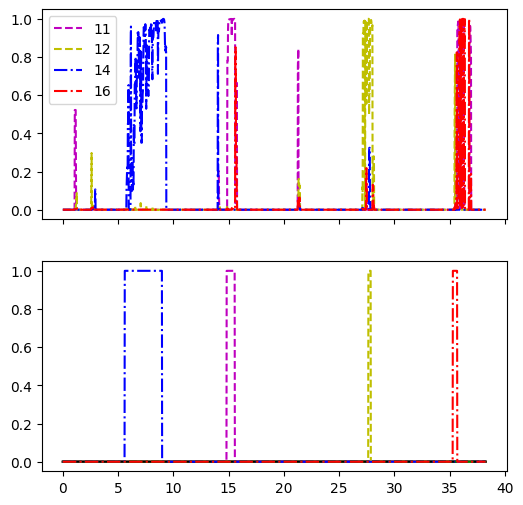

Gesture 14 latency: 14 frames
Gesture 11 latency: 3 frames
Gesture 12 latency: 0 frames
Gesture 16 latency: 17 frames


In [ ]:
import numpy as np
import torch
import tqdm
pos = True
quat = True

fname_ = '{}/test_set/annotations_revised.txt'.format(MAIN_FOLDER)

# Loop through the sequences and output the results and latencys.
for idx in range(109, 110):
  filename = '{}/test_set/sequences/{}.txt'.format(MAIN_FOLDER,idx)

  data_ = np.genfromtxt(filename, delimiter=';')
  data = np.delete(data_, -1, axis=1)

  data = select_joint(data)

  data = torch.from_numpy(data).float()



  label, frame_sequence = read_annotation_idx(fname_, idx-109)
  frame_sequence = np.reshape(frame_sequence, (-1))

  frame_sequence = torch.tensor(frame_sequence, dtype=torch.int32)

  classes = ['ONE', 'TWO', 'THREE', 'FOUR', 'OK', 'MENU', 'LEFT', 'RIGHT', 'CIRCLE', 'V', 'CROSS', 'GRAB', 'PINCH', 'TAP', 'DENY', 'KNOB', 'EXPAND']
  y_true = [classes.index(x) for x in label]
  print(frame_sequence)
  print(y_true)
  print(label)
  #print(data.shape)
  y_pred_list, outputs_list, y_pred_value_list, gating_list = online_rec_frame_based(my_unitBi.module, my_unitMu.module, 250, 1, data)

  #evaluate_model2(frame_sequence, y_true, y_pred_list)
  #print(y_pred_list)
  #print(gating_list)
  online_plot(outputs_list, data, y_true, frame_sequence)
  y_true_temp = [classes.index(x) for x in label]
  indey=0
  for x in range(len(y_pred_list)):
    if indey > len(y_true) - 1:
      break
    if y_true_temp[indey]==y_pred_list[x] and x>=frame_sequence[indey*2]:
      print("Gesture", int(y_true_temp[indey]), "latency:", x - int(frame_sequence[indey*2]), "frames")
      indey = indey + 1


100%|██████████| 1913/1913 [00:02<00:00, 923.38it/s]


Results for the current sequence:
Class 11:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 12:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1581/1581 [00:01<00:00, 927.63it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 16:
  Recall: 1.00
  Average Latency: 15.00 frames




100%|██████████| 1578/1578 [00:01<00:00, 873.82it/s]


Results for the current sequence:
Class 10:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 1.00
  Average Latency: 7.00 frames




100%|██████████| 1708/1708 [00:02<00:00, 780.56it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 7.50 frames
Class 7:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1623/1623 [00:01<00:00, 854.95it/s]


Results for the current sequence:
Class 5:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 15:
  Recall: 1.00
  Average Latency: 6.00 frames




100%|██████████| 1384/1384 [00:01<00:00, 943.53it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 1:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 11:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1718/1718 [00:01<00:00, 894.06it/s]


Results for the current sequence:
Class 4:
  Recall: 1.00
  Average Latency: 6.00 frames
Class 9:
  Recall: 1.00
  Average Latency: 16.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 15:
  Recall: 1.00
  Average Latency: 12.00 frames




100%|██████████| 2095/2095 [00:02<00:00, 879.88it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 9:
  Recall: 1.00
  Average Latency: -0.50 frames




100%|██████████| 1410/1410 [00:01<00:00, 1011.63it/s]


Results for the current sequence:
Class 6:
  Recall: 0.00
  Average Latency: No data
Class 15:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 2003/2003 [00:02<00:00, 731.13it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 10:
  Recall: 1.00
  Average Latency: -1.00 frames




100%|██████████| 1710/1710 [00:01<00:00, 860.12it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 11.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 2155/2155 [00:02<00:00, 895.71it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 6.00 frames
Class 7:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1327/1327 [00:01<00:00, 981.82it/s] 


Results for the current sequence:
Class 8:
  Recall: 0.00
  Average Latency: No data
Class 9:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1328/1328 [00:01<00:00, 937.26it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: 13.00 frames




100%|██████████| 2309/2309 [00:02<00:00, 817.18it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 8:
  Recall: 0.00
  Average Latency: No data
Class 11:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 18.00 frames




100%|██████████| 1713/1713 [00:02<00:00, 801.45it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 3:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 2.00 frames




100%|██████████| 1943/1943 [00:02<00:00, 889.99it/s]


Results for the current sequence:
Class 5:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 10:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: 4.00 frames




100%|██████████| 2199/2199 [00:02<00:00, 873.90it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 6:
  Recall: 1.00
  Average Latency: -6.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 11.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 24.00 frames
Class 15:
  Recall: 1.00
  Average Latency: -21.00 frames




100%|██████████| 1985/1985 [00:02<00:00, 815.69it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 3:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 4:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1850/1850 [00:02<00:00, 819.17it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 10:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1287/1287 [00:01<00:00, 739.44it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 1:
  Recall: 1.00
  Average Latency: 13.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 0.00 frames




100%|██████████| 2231/2231 [00:02<00:00, 798.63it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 6.00 frames




100%|██████████| 1849/1849 [00:02<00:00, 890.32it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 24.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 1.00
  Average Latency: 3.00 frames




100%|██████████| 2115/2115 [00:02<00:00, 804.80it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 6:
  Recall: 1.00
  Average Latency: -3.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 39.00 frames




100%|██████████| 1620/1620 [00:01<00:00, 871.50it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 10.00 frames
Class 2:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 8:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 2066/2066 [00:02<00:00, 784.47it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 12:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 14:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 1.00
  Average Latency: 22.00 frames




100%|██████████| 1276/1276 [00:01<00:00, 854.55it/s]


Results for the current sequence:
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 10:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: 2.00 frames




100%|██████████| 1497/1497 [00:01<00:00, 885.89it/s]


Results for the current sequence:
Class 3:
  Recall: 0.00
  Average Latency: No data
Class 8:
  Recall: 1.00
  Average Latency: 23.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 12.00 frames
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1820/1820 [00:02<00:00, 887.41it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 1.00
  Average Latency: 12.00 frames




100%|██████████| 1770/1770 [00:01<00:00, 888.90it/s]


Results for the current sequence:
Class 5:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 6.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 12:
  Recall: 1.00
  Average Latency: -3.00 frames




100%|██████████| 1210/1210 [00:01<00:00, 916.65it/s] 


Results for the current sequence:
Class 6:
  Recall: 1.00
  Average Latency: 6.00 frames
Class 13:
  Recall: 0.00
  Average Latency: No data
Class 14:
  Recall: 1.00
  Average Latency: 16.00 frames
Class 16:
  Recall: 1.00
  Average Latency: 10.00 frames




100%|██████████| 1551/1551 [00:01<00:00, 807.65it/s]


Results for the current sequence:
Class 6:
  Recall: 0.00
  Average Latency: No data
Class 8:
  Recall: 0.00
  Average Latency: No data
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 14:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1839/1839 [00:02<00:00, 901.91it/s]


Results for the current sequence:
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 0.00
  Average Latency: No data
Class 15:
  Recall: 1.00
  Average Latency: 33.00 frames




100%|██████████| 1605/1605 [00:01<00:00, 924.53it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 2:
  Recall: 0.00
  Average Latency: No data
Class 14:
  Recall: 1.00
  Average Latency: 7.00 frames




100%|██████████| 2109/2109 [00:02<00:00, 866.33it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 0.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: -7.00 frames
Class 16:
  Recall: 1.00
  Average Latency: 5.00 frames




100%|██████████| 1533/1533 [00:01<00:00, 850.18it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 32.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: 4.00 frames




100%|██████████| 1447/1447 [00:01<00:00, 963.11it/s]


Results for the current sequence:
Class 1:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: -5.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 1.00 frames




100%|██████████| 1721/1721 [00:02<00:00, 686.26it/s]


Results for the current sequence:
Class 4:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 7:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 1533/1533 [00:01<00:00, 875.90it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 13.00 frames
Class 3:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 10:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1528/1528 [00:01<00:00, 864.86it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 0.00
  Average Latency: No data
Class 14:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 2278/2278 [00:02<00:00, 850.30it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 4:
  Recall: 0.00
  Average Latency: No data
Class 5:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 11:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 21.00 frames




100%|██████████| 1528/1528 [00:01<00:00, 851.76it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1270/1270 [00:01<00:00, 938.69it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 2:
  Recall: 0.00
  Average Latency: No data
Class 11:
  Recall: 1.00
  Average Latency: 12.00 frames




100%|██████████| 786/786 [00:00<00:00, 815.73it/s]


Results for the current sequence:
Class 11:
  Recall: 1.00
  Average Latency: 6.00 frames
Class 12:
  Recall: 1.00
  Average Latency: 7.00 frames




100%|██████████| 1772/1772 [00:02<00:00, 787.13it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: -3.00 frames
Class 7:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 2414/2414 [00:02<00:00, 915.81it/s]


Results for the current sequence:
Class 4:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 9:
  Recall: 1.00
  Average Latency: -4.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 0.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 2.00 frames




100%|██████████| 1459/1459 [00:01<00:00, 900.80it/s]


Results for the current sequence:
Class 6:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 10:
  Recall: 1.00
  Average Latency: 15.00 frames
Class 14:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1286/1286 [00:01<00:00, 852.38it/s]


Results for the current sequence:
Class 7:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 14:
  Recall: 0.00
  Average Latency: No data
Class 15:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1568/1568 [00:01<00:00, 900.43it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 13.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 10.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 8.00 frames




100%|██████████| 2107/2107 [00:02<00:00, 791.60it/s]


Results for the current sequence:
Class 6:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 9:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1398/1398 [00:01<00:00, 938.04it/s]


Results for the current sequence:
Class 8:
  Recall: 0.00
  Average Latency: No data
Class 14:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1561/1561 [00:01<00:00, 867.99it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 11.00 frames




100%|██████████| 1707/1707 [00:01<00:00, 947.19it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 1.00
  Average Latency: 1.00 frames




100%|██████████| 1681/1681 [00:01<00:00, 887.26it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 9:
  Recall: 1.00
  Average Latency: 13.00 frames
Class 10:
  Recall: 1.00
  Average Latency: -3.00 frames




100%|██████████| 1232/1232 [00:01<00:00, 915.18it/s]


Results for the current sequence:
Class 5:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 11:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 2262/2262 [00:02<00:00, 804.87it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 1:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 8:
  Recall: 1.00
  Average Latency: -2.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 16.00 frames
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1073/1073 [00:01<00:00, 778.80it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 11.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 1.00 frames




100%|██████████| 2118/2118 [00:02<00:00, 897.48it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 27.00 frames
Class 12:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 13:
  Recall: 1.00
  Average Latency: 5.00 frames




100%|██████████| 1794/1794 [00:01<00:00, 909.61it/s]


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 13.00 frames




100%|██████████| 1697/1697 [00:01<00:00, 920.61it/s]


Results for the current sequence:
Class 4:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 8:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 16:
  Recall: 1.00
  Average Latency: 12.00 frames




100%|██████████| 1719/1719 [00:02<00:00, 852.58it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: -1.00 frames
Class 8:
  Recall: 0.00
  Average Latency: No data
Class 10:
  Recall: 0.00
  Average Latency: No data
Class 11:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1421/1421 [00:01<00:00, 839.38it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 15:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1320/1320 [00:01<00:00, 678.06it/s]


Results for the current sequence:
Class 3:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 10.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 8:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1368/1368 [00:01<00:00, 977.45it/s] 


Results for the current sequence:
Class 1:
  Recall: 1.00
  Average Latency: 8.00 frames
Class 4:
  Recall: 0.00
  Average Latency: No data
Class 13:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1481/1481 [00:01<00:00, 901.35it/s]


Results for the current sequence:
Class 4:
  Recall: 1.00
  Average Latency: 11.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1425/1425 [00:01<00:00, 906.66it/s]


Results for the current sequence:
Class 2:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 4:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 11:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 1.00
  Average Latency: 9.00 frames




100%|██████████| 1526/1526 [00:01<00:00, 922.58it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 5:
  Recall: 1.00
  Average Latency: 5.00 frames
Class 14:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 15:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1359/1359 [00:01<00:00, 788.20it/s]


Results for the current sequence:
Class 1:
  Recall: 0.00
  Average Latency: No data
Class 4:
  Recall: 1.00
  Average Latency: 7.00 frames
Class 10:
  Recall: 0.00
  Average Latency: No data
Class 16:
  Recall: 1.00
  Average Latency: 1.00 frames




100%|██████████| 1448/1448 [00:01<00:00, 939.47it/s]


Results for the current sequence:
Class 7:
  Recall: 1.00
  Average Latency: -2.00 frames
Class 10:
  Recall: 1.00
  Average Latency: 1.00 frames
Class 12:
  Recall: 1.00
  Average Latency: 2.00 frames




100%|██████████| 1492/1492 [00:01<00:00, 823.96it/s]


Results for the current sequence:
Class 6:
  Recall: 1.00
  Average Latency: 0.00 frames
Class 7:
  Recall: 0.00
  Average Latency: No data
Class 12:
  Recall: 1.00
  Average Latency: 4.00 frames
Class 16:
  Recall: 1.00
  Average Latency: 1.00 frames




100%|██████████| 1485/1485 [00:01<00:00, 945.82it/s] 


Results for the current sequence:
Class 3:
  Recall: 0.00
  Average Latency: No data
Class 6:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 9:
  Recall: 0.00
  Average Latency: No data




100%|██████████| 1384/1384 [00:01<00:00, 857.83it/s]


Results for the current sequence:
Class 0:
  Recall: 1.00
  Average Latency: 12.00 frames
Class 2:
  Recall: 1.00
  Average Latency: 9.00 frames
Class 6:
  Recall: 1.00
  Average Latency: 3.00 frames
Class 12:
  Recall: 1.00
  Average Latency: 2.00 frames
Class 15:
  Recall: 1.00
  Average Latency: 8.00 frames


Overall Results:
Class 0:
  Total Recall: 1.00
  Total Average Latency: 6.6875 frames
Class 1:
  Total Recall: 0.88
  Total Average Latency: 6.5714 frames
Class 2:
  Total Recall: 0.88
  Total Average Latency: 3.5000 frames
Class 3:
  Total Recall: 0.88
  Total Average Latency: 5.2143 frames
Class 4:
  Total Recall: 0.81
  Total Average Latency: 7.1538 frames
Class 5:
  Total Recall: 1.00
  Total Average Latency: 4.5625 frames
Class 6:
  Total Recall: 0.88
  Total Average Latency: 2.7857 frames
Class 7:
  Total Recall: 0.31
  Total Average Latency: 5.0000 frames
Class 8:
  Total Recall: 0.62
  Total Average Latency: 10.6000 frames
Class 9:
  Total Recall: 0.38
  Total Average L

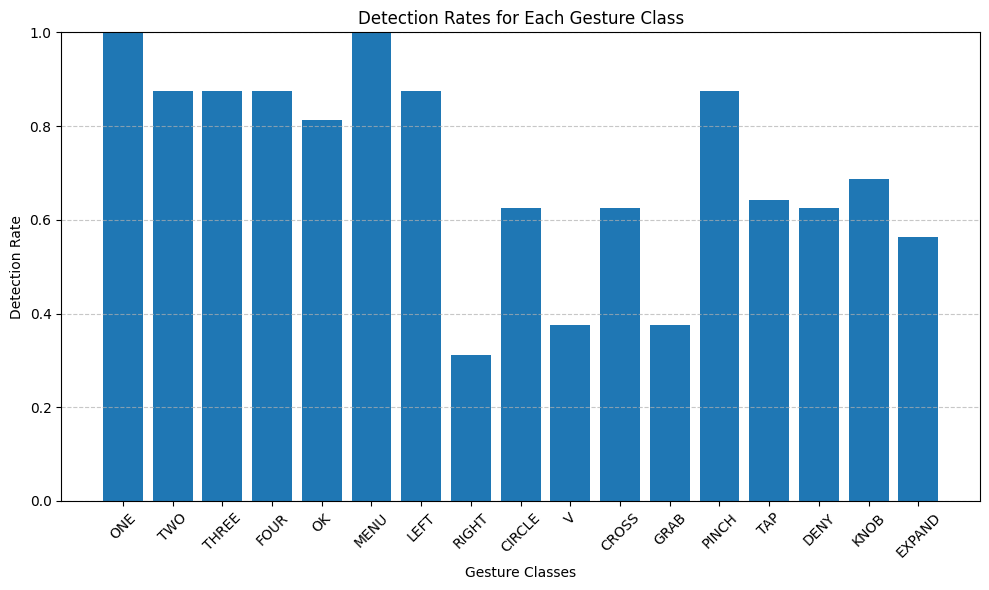

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Initialize global statistics
num_classes = 17
global_total_gestures = [0] * num_classes
global_correct_predictions = [0] * num_classes
global_latencies = [[] for _ in range(num_classes)]
global_jaccard_indices = [[] for _ in range(num_classes)]
global_false_positives = [0] * num_classes
fname_ = '{}/test_set/annotations_revised.txt'.format(MAIN_FOLDER)


def evaluate_jaccard_index(frame_sequence, y_true, gating_list, y_pred_list, num_classes=17):

    # Initialize local statistics variables
    total_gestures = [0] * num_classes
    correct_predictions = [0] * num_classes
    latencies = [[] for _ in range(num_classes)]
    jaccard_indices = [[] for _ in range(num_classes)]  # Store the Jaccard index for each category

    num_gestures = len(frame_sequence) // 2

    # Construct the true label sequence and update the total number of gestures
    for i in range(num_gestures):
        s_true = frame_sequence[2 * i]
        e_true = frame_sequence[2 * i + 1]
        true_class = y_true[i]

        # Update total gesture count
        total_gestures[true_class] += 1

        # Calculate the overlap between the predicted boundary and the true boundary
        s_pred = min(gating_list, key=lambda x: abs(x - s_true))
        e_pred = min(gating_list, key=lambda x: abs(x - e_true))

        # Ensure s_pred <= e_pred
        if s_pred > e_pred:
            s_pred, e_pred = e_pred, s_pred

        # Define evaluation intervals to cover both real and predicted gesture areas
        start = min(s_true, s_pred)
        end = max(e_true, e_pred)

        # Initialize binary vector
        gt_sequence = [0] * (end - start + 1)
        pred_sequence = [0] * (end - start + 1)

        # Fill in the location where the real gesture exists
        for idx in range(s_true - start, e_true - start + 1):
            gt_sequence[idx] = 1

        # Fill in the predicted gesture location (only if the predicted category matches the true category)
        for idx in range(s_pred - start, e_pred - start + 1):
            frame_idx = start + idx
            if y_pred_list[frame_idx] == true_class:
                pred_sequence[idx] = 1

        # Computing intersections and unions
        intersection = sum(1 for gt, pred in zip(gt_sequence, pred_sequence) if gt == 1 and pred == 1)
        union = sum(1 for gt, pred in zip(gt_sequence, pred_sequence) if gt == 1 or pred == 1)

        # Calculate the Jaccard index
        jaccard = intersection / union if union != 0 else 0

        # Add the result to the list of the corresponding category
        jaccard_indices[true_class].append(jaccard)

    # Calculate the average Jaccard index for each category
    average_jaccards = []
    for indices in jaccard_indices:
        if indices:
            avg_jaccard = sum(indices) / len(indices)
        else:
            avg_jaccard = None
        average_jaccards.append(avg_jaccard)

    # Update global statistics variables
    for i in range(num_classes):
        global_total_gestures[i] += total_gestures[i]
        # If necessary, the global correct prediction count and delay can be updated
        # global_correct_predictions[i] += correct_predictions[i]
        # global_latencies[i].extend(latencies[i])

        # Update the global Jaccard index list
        if average_jaccards[i] is not None:
            global_jaccard_indices[i].append(average_jaccards[i])

    # Output the results of the current sequence
    print(f"Results for the current sequence:")
    for i in range(num_classes):
        if average_jaccards[i] is not None:
            print(f"Class {i}: Average Jaccard Index: {average_jaccards[i]:.2f}")
        else:
            print(f"Class {i}: No data")
    print("\n")


def evaluate_detection_rate(frame_sequence, y_true, gating_list, y_pred_list, num_classes=17):
    # Local statistics
    total_gestures = [0] * num_classes
    correct_predictions = [0] * num_classes
    latencies = [[] for _ in range(num_classes)]

    num_gestures = len(frame_sequence) // 2

    for i in range(num_gestures):
        s_true = frame_sequence[2 * i]
        e_true = frame_sequence[2 * i + 1]
        true_class = y_true[i]

        # Update total gestures
        total_gestures[true_class] += 1  # Class indices from 0 to 16

        # Find the closest predicted boundaries to the true boundaries
        s_pred = min(gating_list, key=lambda x: abs(x - s_true))
        e_pred = min(gating_list, key=lambda x: abs(x - e_true))

        # Ensure s_pred <= e_pred
        if s_pred > e_pred:
            s_pred, e_pred = e_pred, s_pred

        # Extract predictions within the predicted interval
        y_pred_interval = y_pred_list[s_pred:e_pred + 1]
        #print(y_pred_interval)
        y_pred_interval = [label for label in y_pred_interval if label != -1]

        if not y_pred_interval:

            continue  # No valid predictions in this interval

        # Determine the most frequent class label
        predicted_class = max(set(y_pred_interval), key=y_pred_interval.count)

        # Calculate Intersection over Union (IoU)
        intersection = max(0, abs(min(e_true, e_pred) - max(s_true, s_pred)) + 1)
        union = max(e_true, e_pred) - min(s_true, s_pred) + 1
        iou = intersection / union
        #print(predicted_class, true_class)

        # Check if prediction is correct
        if predicted_class == true_class and iou > 0.5:
            # Update correct predictions
            correct_predictions[true_class] += 1


            # Calculate latency
            # Find the first occurrence of the predicted class in y_pred_list within the predicted interval
            for idx in range(s_pred, e_pred + 1):
                if y_pred_list[idx] == predicted_class:
                    first_correct_frame = idx
                    break
            else:
                first_correct_frame = s_pred  # Default to s_pred if not found

            latency = first_correct_frame - s_true
            latencies[true_class].append(latency)

    # Update global statistics (assuming global variables are defined elsewhere)
    for i in range(num_classes):
        global_total_gestures[i] += total_gestures[i]
        global_correct_predictions[i] += correct_predictions[i]
        global_latencies[i].extend(latencies[i])

    # Calculate recall and average latency for this sequence
    recalls = []
    average_latencies = []
    for i in range(num_classes):
        if total_gestures[i] > 0:
            recall = correct_predictions[i] / total_gestures[i]
        else:
            recall = None
        recalls.append(recall)

        if latencies[i]:
            avg_latency = sum(latencies[i]) / len(latencies[i])
        else:
            avg_latency = None
        average_latencies.append(avg_latency)

    # Output results for this sequence
    print(f"Results for the current sequence:")
    for i in range(num_classes):
        if total_gestures[i] > 0:
            print(f"Class {i}:")
            print(f"  Recall: {recalls[i]:.2f}")
            if average_latencies[i] is not None:
                print(f"  Average Latency: {average_latencies[i]:.2f} frames")
            else:
                print("  Average Latency: No data")
    print("\n")

def evaluate_model_with_fpr(frame_sequence, y_true, gating_list, y_pred_list, num_classes=17):
    global global_total_gestures
    global global_false_positives

    # Initialize local statistics variables
    total_gestures = [0] * num_classes  # The total number of true gestures for each category
    false_positives = [0] * num_classes  # The number of false positives for each class
    num_gestures = len(frame_sequence) // 2  # The number of real gestures

    # Constructing a list of prediction intervals
    predicted_intervals = []
    num_preds = len(gating_list) // 2
    for i in range(num_preds):
        s_pred = gating_list[2 * i]
        e_pred = gating_list[2 * i + 1]
        predicted_intervals.append({'start': s_pred, 'end': e_pred, 'used': False})

    # Iterate through each real gesture
    for i in range(num_gestures):
        s_true = frame_sequence[2 * i]
        e_true = frame_sequence[2 * i + 1]
        true_class = y_true[i]
        total_gestures[true_class] += 1  # Update the total number of real gestures

        # Find the predicted boundary that is closest to the true gesture boundary
        all_boundaries = [interval['start'] for interval in predicted_intervals if not interval['used']] + \
                         [interval['end'] for interval in predicted_intervals if not interval['used']]
        if not all_boundaries:
            continue  # No unused prediction boundaries, skipping

        s_pred = min(all_boundaries, key=lambda x: abs(x - s_true))
        e_pred = min(all_boundaries, key=lambda x: abs(x - e_true))

        # Ensure s_pred <= e_pred
        if s_pred > e_pred:
            s_pred, e_pred = e_pred, s_pred

        # Mark which prediction intervals are used
        used_intervals = []
        for idx, interval in enumerate(predicted_intervals):
            if interval['used']:
                continue
            # Determine whether the prediction interval overlaps with the combined interval
            if interval['end'] >= s_pred and interval['start'] <= e_pred:
                predicted_intervals[idx]['used'] = True
                used_intervals.append(interval)

        # If no prediction interval is matched, skip
        if not used_intervals:
            continue

        # Extract the prediction labels within the combined prediction interval
        y_pred_interval = y_pred_list[s_pred:e_pred + 1]
        y_pred_interval = [label for label in y_pred_interval if label != -1]
        if not y_pred_interval:
            continue  # No valid prediction, skipping

        # Determine the most frequent prediction category
        predicted_class = max(set(y_pred_interval), key=y_pred_interval.count)

        # Calculate the Intersection over Union (IoU)
        intersection = max(0, min(e_true, e_pred) - max(s_true, s_pred) + 1)
        union = max(e_true, e_pred) - min(s_true, s_pred) + 1
        iou = intersection / union

        # Determine whether the prediction is correct
        if not (predicted_class == true_class and iou > 0.5):
            # Prediction error, counted as false positive
            false_positives[predicted_class] += 1

    # Count the remaining unused prediction intervals as false positives
    for interval in predicted_intervals:
        if interval['used']:
            continue
        s_pred = interval['start']
        e_pred = interval['end']
        # Extract the predicted labels within the prediction interval
        y_pred_interval = y_pred_list[s_pred:e_pred + 1]
        y_pred_interval = [label for label in y_pred_interval if label != -1]
        if not y_pred_interval:
            continue  # No valid prediction, skipping
        # Determine the most frequent prediction category
        predicted_class = max(set(y_pred_interval), key=y_pred_interval.count)
        false_positives[predicted_class] += 1

    # Update global statistics variables
    for i in range(num_classes):
        global_total_gestures[i] += total_gestures[i]
        global_false_positives[i] += false_positives[i]

    # Calculate the false positive rate of this sequence
    fprs = []
    for i in range(num_classes):
        denom = false_positives[i] + total_gestures[i]
        if denom > 0:
            fpr = false_positives[i] / denom
        else:
            fpr = None
        fprs.append(fpr)

    # Output the results of this sequence
    print(f"Results for the current sequence:")
    for i in range(num_classes):
        if total_gestures[i] > 0 or false_positives[i] > 0:
            print(f"Class {i}:")
            if fprs[i] is not None:
                print(f"  False Positive Rate: {fprs[i]:.2f}")
            else:
                print(f"  False Positive Rate: No data")
    print("\n")





# Main loop to process multiple sequences
for idx in range(109, 181):  # Adjust the sequence range as needed
    filename = '{}/test_set/sequences/{}.txt'.format(MAIN_FOLDER, idx)
    data_ = np.genfromtxt(filename, delimiter=';')
    data = np.delete(data_, -1, axis=1)
    data = select_joint(data)
    data = torch.from_numpy(data).float()

    label, frame_sequence = read_annotation_idx(fname_, idx - 109)
    frame_sequence = np.reshape(frame_sequence, (-1))
    frame_sequence = torch.tensor(frame_sequence, dtype=torch.int32)

    classes = ['ONE', 'TWO', 'THREE', 'FOUR', 'OK', 'MENU', 'LEFT', 'RIGHT', 'CIRCLE',
               'V', 'CROSS', 'GRAB', 'PINCH', 'TAP', 'DENY', 'KNOB', 'EXPAND']
    class_to_index = {class_name: idx for idx, class_name in enumerate(classes)}
    y_true = [class_to_index[x] for x in label]

    y_pred_list, outputs_list, y_pred_value_list, gating_list = online_rec_frame_based(my_unitBi.module, my_unitMu.module, 250, 1, data)

    # Call evaluate_model function
    #evaluate_model_with_fpr(frame_sequence, y_true, gating_list, y_pred_list)
    evaluate_detection_rate(frame_sequence, y_true, gating_list, y_pred_list)
    #evaluate_jaccard_index(frame_sequence, y_true, gating_list, y_pred_list)

# After processing all sequences, calculate overall recall and average latency
final_recalls = []
final_average_latencies = []
final_average_jaccard_indices = []
for i in range(num_classes):
    if global_total_gestures[i] > 0:
        recall = global_correct_predictions[i] / global_total_gestures[i]
    else:
        recall = None
    final_recalls.append(recall)

    if global_latencies[i]:
        avg_latency = sum(global_latencies[i]) / len(global_latencies[i])
    else:
        avg_latency = None
    final_average_latencies.append(avg_latency)


# Output overall results
print("Overall Results:")
for i in range(num_classes):
    if global_total_gestures[i] > 0:
        print(f"Class {i}:")
        print(f"  Total Recall: {final_recalls[i]:.2f}")
        if final_average_latencies[i] is not None:
            print(f"  Total Average Latency: {final_average_latencies[i]:.4f} frames")
        else:
            print("  Total Average Latency: No data")
print("\n")

# After processing all sequences, the global average Jaccard index for each category is calculated
final_average_jaccard_indices = []
for i in range(num_classes):
    if global_jaccard_indices[i]:
        average_jaccard = sum(global_jaccard_indices[i]) / len(global_jaccard_indices[i])
    else:
        average_jaccard = None
    final_average_jaccard_indices.append(average_jaccard)

# Output overall results
print("Overall Results:")
for i in range(num_classes):
    if global_total_gestures[i] > 0:
        print(f"Class {i}:")
        if final_average_jaccard_indices[i] is not None:
            print(f"  Total Average Jaccard Index: {final_average_jaccard_indices[i]:.4f}")
        else:
            print("  Total Average Jaccard Index: No data")
print("\n")

# After all sequences are processed, the global result is calculated and output
print("Global Results:")
for i in range(num_classes):
    denom = global_false_positives[i] + global_total_gestures[i]
    if denom > 0:
        fpr = global_false_positives[i] / denom
    else:
        fpr = None

    if global_total_gestures[i] > 0 or global_false_positives[i] > 0:
        print(f"Class {i}:")
        if fpr is not None:
            print(f"  False Positive Rate: {fpr:.2f}")
        else:
            print(f"  False Positive Rate: No data")

print("\n")


# Plotting the recall rates as a bar chart
# Replace None with 0 for plotting purposes
plot_recalls = [recall if recall is not None else 0 for recall in final_recalls]

plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), plot_recalls, tick_label=classes)
plt.xlabel('Gesture Classes')
plt.ylabel('Detection Rate')
plt.title('Detection Rates for Each Gesture Class')
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
